# 主題: 判斷照片中的人是否有正確地配戴口罩
### 組員: 統計三 李姿璇 胡馨尹 陳淳蓁 歐陽宇珊
### 一、動機: 
前陣子因處於新冠肺炎疫情高峰期，人心惶惶，因此政府規定民眾出入公共場所、搭乘大眾運輸工具需要配戴口罩，並派遣大量人力於各捷運站出入口人工檢查並提醒乘客入站是否配戴口罩。
出門戴口罩現已為必備的防疫措施，然而，正確的配戴口罩才有防護效果。若是露出鼻子、口罩下擺沒有包覆到下巴，都會對防護效果大打折扣。因此，我們想用人工智慧來辨識一張人像照片是否有正確的佩戴口罩。若成功，此項技術可協助政府、學校等各機關，應用在課堂或大眾交通工具上，透過這組程式將監視器錄到的影像或拍攝的相片中沒有正確配戴口罩的人篩出。

### 二、資料蒐集
* 網路爬蟲
* 以Fatkun Batch Download Image 批次下載圖片

* 網路爬蟲
    1. 瀏覽器：Chrome、Firefox
        * 選定想要使用的瀏覽器後，要先安裝驅動程式
    2. 搜尋引擎：Bing、Google、百度、搜狗
        * 不同的搜尋引擎一次可以存取的圖片量、擋爬蟲的程度皆不同
        * 在程式碼當中可以加入time.sleep()以避免瀏覽器認為你在攻擊它
        * Google的反爬蟲機制最強
    3. 關鍵字：戴口罩、wearing mask、人像...等等

#### 程式碼 (以Firefox + 百度搜尋為例)

In [2]:
#讀取套件
from selenium import webdriver
import time
import urllib
import os

In [3]:
#存圖位置(要放圖片的資料夾路徑)
local_path = r"C:\Users\ena88\Desktop\MASK"

In [8]:
#瀏覽器驅動程式的路徑
driverPath = r"C:\Program Files\Mozilla Firefox\geckodriver_win64"
#以該瀏覽器打開一個新的頁面
driver = webdriver.Firefox(driverPath)

In [9]:
#前往百度圖片搜尋的網址
driver.get("http://image.baidu.com")

In [10]:
#暫停執行1秒
time.sleep(1)

In [11]:
#找到搜尋引擎輸入文字的框
search_input = driver.find_element_by_name("word")
#輸入wearing mask
search_input.send_keys('wearing mask')

In [12]:
#暫停執行兩秒
time.sleep(2)

In [13]:
#找到搜尋按鈕
start_search_btn = driver.find_element_by_class_name("s_search")
#按下搜尋按鈕
start_search_btn.click()

In [14]:
# 設置一個空的字典
img_url_dic = {}

設定xpath
* 自己先手動以相同關鍵字搜尋，選一張圖片按下右鍵，按下檢查
* 接著看其img class為何，可以多看幾張照片看其img class是否相同
* 可能會有多種img class，設置xpath時可以都試

In [15]:
#設定xpath
xpath = '//img[@class="main_img img-hover"]'

pos = 0  
#### 圖片編號
m = 0  
for i in range(100):
    #每次下滾500
    pos += i*500   
    js = "document.documentElement.scrollTop=%d" % pos  
    driver.execute_script(js)  
    time.sleep(5)
    
    for element in driver.find_elements_by_xpath(xpath):
        try:
            #找圖片的url，每個搜尋引擎放url的代號有些不同
            #可以在前面找xpath的時候一起看 在圖片xpath後面會有該圖片的url
            #這邊存url的代號是src
            img_url = element.get_attribute('src')
            
            #保存圖片到指定路徑
            if img_url != None and not img_url in img_url_dic:
                img_url_dic[img_url] = ''  
                m += 1
                #print(img_url)
                ext = img_url.split('/')[-1]
                #print(ext)
                filename = str(m) + 'B' + '_' + ext +'.jpg'
                print(filename)
                
                #保存圖片
                urllib.request.urlretrieve(img_url,os.path.join(local_path ,filename))
                
        except OSError:
            print('發生OSError!')
            print(pos)
            break;
#### 關閉瀏覽器            
driver.close()

* Fatkun Batch Download Image
   1. 在Chrome線上應用程式商店下載 Fatkun Batch Download Image 到瀏覽器
   2. 點選此工具後，會出現兩個選項：「下載當前頁面」和「下載所有頁面」。前者只會下載當前分頁的所有圖片；另一個選項則會下載所有開啟分頁的圖片。若網站有下載的限制，勾選「解除當前頁面下載限制」即可順利下載。
       - 內部有進階的設定，例如將下載的圖片自動轉擋成.jpg或.png
   3. 點擊下載後，就開啟此工具，此時頁面會出現要下載的圖片以及篩選條件。
       - 篩選條件包括：圖片尺寸、關鍵字、頁面

### 三、資料篩選
* 人工篩選：我們將爬蟲取得的圖片以人工的方式篩選，將明顯不是人像的圖片刪除。

### 四、資料處理
1. 將圖片resize成 256*256
    * 以PIL套件處理
2. 僅保留(256,256,3)的圖片
    * 讀入資料後，篩掉(256,256,1)、(256,256,4)的圖片
    * 最後以4539張圖片進行模型的訓練與測試
3. 將資料標籤成0,1 
    * 0代表沒戴口罩、1代表有戴口罩

#### 讀取圖片方法、影像處理套件的差異：
* Opencv
    - 優點
        1. 易於使用：Python 是一門易於學習的語言（尤其是與 C 對比），所以我們理應把其當作為第一門語言來學習程式設計。
        2. 視覺化及除錯 ：現在 Python 環境下比 C 更容易去除錯程式碼。
    - 缺點
        1. 薄弱的文件 ：OpenCV（Python）的文件並不太的完善， 新手使用時往往會陷入如何去使用特定函式的問題當中。
        2. 執行時較慢 ：比起 C ，Python中的程式一般會執行地更慢。
        3. OpenCV 是使用 C/C 編寫的 ：作為一個開源庫，其好處之一就是能根據你自身需求進行修改。如果你想要修改 OpenCV，你就必須得修改 OpenCV 的 C/C 原始檔。
    - 我們實際使用的經驗
      * 我們在使用opencv時，運用了其中的靜態人臉辨識功能，但我們發現效果並不如預期，辨識出來的位置往往不是最主要的人臉，有時是背景的某一區塊、有時是旁邊路人甲乙的臉，因此我們不使用opencv來調整、剪裁我們的照片。
* Matplotlib.Image
    - 優點
        1. 相較於其他視覺化套件，matplot算是最歷史悠久，有很多教學文章或範例可參考。 
        2. 畫圖功能最齊全
        3. Python中常用的讀取圖片套件之一
    - 缺點
        1. 依賴其他套件，像是Numpy
        2. 只能讀取png檔
* Python Image Library (PIL)
        
    * PIL是Python強大的圖像處理庫，功能包含：基本圖像操作、圖像儲存、顯示、格式轉換…等多種功能，目前已經停止開發；pillow開發活躍，且支持Python3.x，所以現在所使用的PIL基本上都是pillow模塊。
    * 優點：只適用於Python，較可靠、穩定
    * 缺點：其他程式難以使用

* 三者比較

    * 另外，Pillow可以使用的唯一數據類型是uint8。Matplotlib可以處理float32和uint8，但是除了PNG以外的任何格式的圖像都受限於uint8。大多數顯示器每個channel只能渲染8位色彩等級，因為這就是人眼所能看到的全部。
    * 經過測試與比較，此次專案我們選用的是PIL方法來裁剪圖片，將不同大小的圖片都裁成256x256的大小，以利後續模型的資料輸入。


#### 程式碼---以PIL進行resize

In [16]:
%matplotlib inline

import os
import os.path
import glob
from PIL import Image
import matplotlib.pyplot as plt # plt 用於顯示圖片
import matplotlib.image as mpimg # mpimg 用於讀取圖片
import numpy as np
from sklearn import model_selection

In [19]:
# 用雲端資料夾
#from google.colab import drive
#drive.mount('/content/gdrive')

In [20]:
#os.chdir("gdrive/My Drive/Colab Notebooks")

In [21]:
# 以PIL進行resize
def convertjpg(jpgfile,outdir,width=256,height=256):
    img=Image.open(jpgfile)
    try:
        new_img=img.resize((width,height),Image.BILINEAR)   
        new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
    except Exception as e:
        print(e)

### 五、資料標籤、打亂資料

資料整理流程圖
(https://github.com/unique4761453/python_1082/blob/master/DataDiagram.jpg)

In [22]:
array_of_img = []
array_of_img_2=[]
array_of_img_3=[]
array_of_img_4=[]

In [23]:
def read_directory(directory_name):
#    global array_of_img
    for filename in os.listdir(r"./"+directory_name):        #從程式碼所在的路徑尋找要讀入圖片的資料夾
        img = mpimg.imread(directory_name + "/" + filename)  #讀入資料夾下的圖片
        if img.shape==((256,256,3)):      ##如果是RGB三色就留下來，黑白的剔除
            #print(len(array_of_img))      
            array_of_img.append(img)      ##用list的方式append
            #array_of_img_2.append(img)
            #array_of_img_3.append(img)
            #array_of_img_4.append(img)
        else :
            print(filename) 

In [24]:
#讀入資料
#read_directory("單人_trans")
#read_directory("多人_trans")
#read_directory("單人_trans(non)")
#read_directory("多人_trans(non)")

In [25]:
#統一從list轉成ndarray
array_of_img=np.array(array_of_img)     #單人_trans 有戴
array_of_img_2=np.array(array_of_img_2) #多人_trans 有戴
array_of_img_3=np.array(array_of_img_3) #單人_trans(non) 沒戴
array_of_img_4=np.array(array_of_img_4) #多人_trans(non) 沒戴

In [26]:
#合併x資料集
mask=np.append(array_of_img,array_of_img_2, axis=0)
nonmask=np.append(array_of_img_3,array_of_img_4, axis=0)
x=np.append(mask,nonmask, axis=0)

In [27]:
#合併y資料集
y_1 = np.ones(len(mask))
y_0 = np.zeros(len(nonmask))
y=np.append(y_1,y_0, axis=0)

In [28]:
indices =np.random.permutation(x.shape[0])    #隨機排列同樣長度的序號

In [30]:
#x = x[indices,:,:,:]        #獲取打亂後的訓練資料
#y = y[indices]              #讓y隨著x的順序一起打亂

In [31]:
#儲存x,y資料集
#np.save(file="x.npy", arr=x)
#np.save(file="y.npy", arr=y)

### 六、讀入整理過的資料並檢視

In [32]:
x= np.load(file="x.npy")

In [33]:
y= np.load(file="y.npy")

In [34]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, random_state=0)

In [35]:
x_train.shape

(3631, 256, 256, 3)

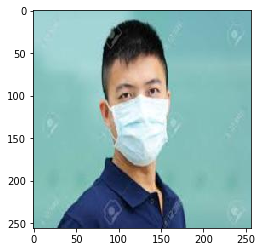

In [37]:
plt.imshow(x_train[500])

In [38]:
y_train[500]

1.0

In [39]:
x_test.shape

(908, 256, 256, 3)

In [8]:
y_train.shape

(3631,)

In [52]:
# Import some useful packages
import matplotlib.pyplot as plt
import numpy as np

# Layers for FNN
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten

# Layers for CNN
from keras.layers import Conv2D,Conv3D,AveragePooling2D, MaxPooling2D, AveragePooling3D,MaxPooling3D

from keras.optimizers import SGD, Adam,Adagrad

# For data preprocessing
from keras import datasets
from keras.utils import to_categorical

In [53]:
# Normalize the range of featurs
x_train = x_train /255
x_test = x_test / 255

# One-hot encoding
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

### 七、模型架構

模型架構圖(https://github.com/unique4761453/python_1082/blob/master/FunctionalDiagram.jpg)

In [14]:
from keras.models import Model
from keras.layers import Input
from keras.layers import concatenate, add

SPP圖解(https://github.com/unique4761453/python_1082)

In [46]:
from keras.engine.topology import Layer
import keras.backend as K

##SPP空間金字塔池化
class SpatialPyramidPooling(Layer):
    """Spatial pyramid pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_list: list of int
            List of pooling regions to use. The length of the list is the number of pooling regions,
            each int in the list is the number of regions in that pool. For example [1,2,4] would be 3
            regions with 1, 2x2 and 4x4 max pools, so 21 outputs per feature map
    # Input shape
        4D tensor with shape:
        `(samples, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(samples, rows, cols, channels)` if dim_ordering='tf'.
    # Output shape
        2D tensor with shape:
        `(samples, channels * sum([i * i for i in pool_list])`
    """

    def __init__(self, pool_list, **kwargs):

        self.dim_ordering = K.image_data_format()
        assert self.dim_ordering in {'channels_last', 'channels_first'}, 'dim_ordering must be in {tf, th}'

        self.pool_list = pool_list

        self.num_outputs_per_channel = sum([i * i for i in pool_list])

        super(SpatialPyramidPooling, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'channels_first':
            self.nb_channels = input_shape[1]
        elif self.dim_ordering == 'channels_last':
            self.nb_channels = input_shape[3]

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.nb_channels * self.num_outputs_per_channel)

    def get_config(self):
        config = {'pool_list': self.pool_list}
        base_config = super(SpatialPyramidPooling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, x, mask=None):

        input_shape = K.shape(x)

        if self.dim_ordering == 'channels_first':
            num_rows = input_shape[2]
            num_cols = input_shape[3]
        elif self.dim_ordering == 'channels_last':
            num_rows = input_shape[1]
            num_cols = input_shape[2]

        row_length = [K.cast(num_rows, 'float32') / i for i in self.pool_list]
        col_length = [K.cast(num_cols, 'float32') / i for i in self.pool_list]

        outputs = []

        if self.dim_ordering == 'channels_first':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')
                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]
                        x_crop = x[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

        elif self.dim_ordering == 'channels_last':
            for pool_num, num_pool_regions in enumerate(self.pool_list):
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = ix * col_length[pool_num]
                        x2 = ix * col_length[pool_num] + col_length[pool_num]
                        y1 = jy * row_length[pool_num]
                        y2 = jy * row_length[pool_num] + row_length[pool_num]

                        x1 = K.cast(K.round(x1), 'int32')
                        x2 = K.cast(K.round(x2), 'int32')
                        y1 = K.cast(K.round(y1), 'int32')
                        y2 = K.cast(K.round(y2), 'int32')

                        new_shape = [input_shape[0], y2 - y1,
                                     x2 - x1, input_shape[3]]

                        x_crop = x[:, y1:y2, x1:x2, :]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(1, 2))
                        outputs.append(pooled_val)

        if self.dim_ordering == 'channels_first':
            outputs = K.concatenate(outputs)
        elif self.dim_ordering == 'channels_last':
            #outputs = K.concatenate(outputs,axis = 1)
            outputs = K.concatenate(outputs)
            #outputs = K.reshape(outputs,(len(self.pool_list),self.num_outputs_per_channel,input_shape[0],input_shape[1]))
            #outputs = K.permute_dimensions(outputs,(3,1,0,2))
            #outputs = K.reshape(outputs,(input_shape[0], self.num_outputs_per_channel * self.nb_channels))

        return outputs

#### Max-Pooling vs. Average-Pooling
池化操作時在卷積神經網路中經常採用過的一個基本操作，一般在卷積層後面都會接一個池化操作。

|  Max-Pooling   | Average-Pooling  |
|:----|:----|
| 對領域內取最大特徵點  | 對領域內特徵點取平均 |
| 減小卷積層引數誤差造成估計均值的偏移  | 減小鄰域大小受限造成的估計值方差 |
|  保留更多紋理資訊   | 保留更多影象的背景資訊  |
|  效果較好，弱化強特徵值，但可能有過度擬合的情形發生。  | 雖然會弱化強特徵值，但在減少引數維度的貢獻上較大，並體現在資訊的完整傳遞。  |
 
兩種方法各有優劣，端看專案的需求。


Max-Pooling vs. Average-Pooling圖解(https://github.com/unique4761453/python_1082/blob/master/MaxAverage.jpg)

In [49]:
f_1 = Conv2D(16,(3,3),padding='same',activation= 'relu')
f_2 = MaxPooling2D(pool_size=(2,2),padding='same')
f_3 = Conv2D(32,(3,3),padding='same',activation= 'relu')
f_4_1 = MaxPooling2D(pool_size=(2, 2),padding='same', data_format=None)




f_4_2 = AveragePooling2D(pool_size=(2, 2 ),padding='same', data_format=None)
f_5 = Conv2D(128,(3,3),padding='same',activation= 'relu')

f_6 = SpatialPyramidPooling([1, 2, 4])
#f_7 = Flatten()

f_8 = Dense(2, activation='softmax')


In [50]:
x = Input(shape=(256,256,3))

In [51]:
print(x)

Tensor("input_8:0", shape=(None, 256, 256, 3), dtype=float32)


In [52]:
h_1 = f_1(x)
h_2 = f_2(h_1)
h_3 = f_3(h_2)
h_4_1 = f_4_1(h_3)
h_5_1 = f_5(h_4_1)


h_4_2 = f_4_2(h_3)
h_5_2 = f_5(h_4_2)


h_6 = concatenate([h_5_1, h_5_2])
h_7 = f_6(h_6)
#h_8 = f_7(h_7)
y= f_8(h_7)

In [53]:
model = Model(x, y)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 256, 256, 16) 448         input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_15 (MaxPooling2D) (None, 128, 128, 16) 0           conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 32) 4640        max_pooling2d_15[0][0]           
____________________________________________________________________________________________

In [54]:
#model.compile(loss='mse', optimizer=Adam(), metrics=['accuracy'])

In [55]:
model.compile(loss= "binary_crossentropy",optimizer="Adagrad",metrics=["accuracy"])

### 八、開始訓練

In [56]:
model.fit(x_train,y_train,batch_size=32,epochs=12,validation_data=(x_test,y_test))

Train on 3631 samples, validate on 908 samples
Epoch 1/12
3631/3631 [==============================] - 389s 107ms/step - loss: 0.7024 - accuracy: 0.5830 - val_loss: 0.6581 - val_accuracy: 0.5914
Epoch 2/12
3631/3631 [==============================] - 362s 100ms/step - loss: 0.6484 - accuracy: 0.6155 - val_loss: 0.6837 - val_accuracy: 0.5881
Epoch 3/12
3631/3631 [==============================] - 362s 100ms/step - loss: 0.6046 - accuracy: 0.6648 - val_loss: 0.6271 - val_accuracy: 0.6267
Epoch 4/12
3631/3631 [==============================] - 370s 102ms/step - loss: 0.5558 - accuracy: 0.7161 - val_loss: 0.5611 - val_accuracy: 0.6982
Epoch 5/12
3631/3631 [==============================] - 367s 101ms/step - loss: 0.5091 - accuracy: 0.7571 - val_loss: 0.5485 - val_accuracy: 0.7368
Epoch 6/12
3631/3631 [==============================] - 377s 104ms/step - loss: 0.4855 - accuracy: 0.7722 - val_loss: 0.5966 - val_accuracy: 0.6817
Epoch 7/12
3631/3631 [==============================] - 372s 102m

#### Loss Function 損失函數
* MSE (Mean Squared Error)
    * 我們之前講的最小平方法(Least Square)的目標函數 – 預測值與實際值的差距之平均值。
    * MSE雖然好用，但仍然有缺點，Outlier在MSE會指數性的被放大。
* MAE (Mean-Absolute Error)
    * MSE對Outlier特別敏感，由於MAE使用的是L1距離，相較於MSE，對Outlier更為強大，然而MAE為人詬病的缺點就是收斂速度慢。
* Cross Entropy (Categorical Crossentropy)
    * 當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值。在梯度下時，Cross Entropy 計算速度較快，Binary Crossentropy是其中一種變形。


In [57]:
model.save("myCNNFunctionalAPImodelSPP.h5")

In [44]:
from keras.models import load_model

Using TensorFlow backend.


In [49]:
# 從 HDF5 檔案中載入模型
model = load_model('myCNNFunctionalAPImodelSPP.h5', custom_objects={'SpatialPyramidPooling': SpatialPyramidPooling})

In [54]:
# 驗證模型
score = model.evaluate(x_test, y_test, verbose=0)

# 輸出結果
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.44688293298435633
Test accuracy: 0.7984581589698792


### 九、小結論 
我們經過多次討論和不斷嘗試之後，得出了最終模型，但是這個模型還有許多不足之處，我們之後可能還會對其進行修正。目前訓練資料的正確率已經達到0.8474，而測試資料的正確率也有0.7985，基本上可以排除overfitting的問題。
我們在這次的報告當中也遇到許多值得更加深入研究的問題，比如卷積層的層數對結果的影響，dropout，SPP，Conv3D，MaxPooling3D，可以讓我們更加瞭解機器學習是如何運作的。